# comparison of accessibility of nucleotides in the sequences

In [1]:
%load_ext autoreload
%autoreload 2
%matplotlib inline
from eden.util import configure_logging
import logging
configure_logging(logging.getLogger(),verbosity=3)
import sys
sys.path.insert(0,'..')
from IPython.core.display import HTML
HTML('<style>.container { width:95% !important; }</style><style>.output_png {display: table-cell;text-align: center;vertical-align: middle;}</style>')
import matplotlib.pyplot as plt

backend module://ipykernel.pylab.backend_inline version unknown


# Load data

In [2]:
import rna_tools.rna_io as rio

def getdata():
    return rio.get_all_data("../data/RNA16.react","../data/RNA16.dbn")  # {key: rea, seq, stru}

data = getdata()

for k,v in data.items():print k,"\t",  len(v[1])

TRP5 	202
5srRNA 	170
GLYCFN 	205
RNAsep 	154
adenin 	71
Z-CIDGMP-1 	135
R009 	1542
ZHCV 	95
MDLOOP 	80
srRNA 	120
p564 	155
tRNAphe 	76
ZGLY 	198
23sRNA 	2904
ADDRSW 	121
tRNA-asp 	75


# train predict

In [3]:
import simushape as sim
from rna_tools.rnaplfold import rnaplfold

data = getdata()
model  = sim.make_model(data,['23sRNA','R009'])
data.pop("23sRNA")
data.pop("R009")

keys = data.keys()

def get_str(seq):
    for _, data_seq, db in data.values():
        if seq == data_seq:
            return [db]
    print "SHIT"
    
predictions = { k: (data[k][1],sim.predict(model,data[k][1])) for k in keys  }
predictions_str = { k: (data[k][1],sim.predict(model,data[k][1], seq_to_db_function=get_str)) for k in keys  }
acc_shaker = {k: rnaplfold(*predictions[k]) for  k in keys} # a predcition is seq,rea
acc_shaker_str = {k: rnaplfold(*predictions_str[k]) for  k in keys} # a predcition is seq,rea


In [4]:
if False:
    data = getdata()
    keys = data.keys()
    shaker_shape = sim.crosspredict_nfold(data,keys)
    

# real and sukosd based accessibility

In [5]:
from rna_tools.sukosd import sukosd
acc_suko =   {k: rnaplfold(data[k][1], sukosd(data[k][2]) ) for  k in keys}
acc_shape =  {k: rnaplfold(data[k][1],data[k][0]) for  k in keys}  
acc_nodata = {k: rnaplfold(data[k][1]) for  k in keys}


acc_theoretical_best = {k: rnaplfold(data[k][1],[1.0 if e =='.' else 0.0 for e in data[k][2]]) for k in keys} ### DOES THIS WORK? 


In [6]:
from scipy.stats import spearmanr as spear
corr = lambda ac1, ac2:[spear(ac1[k], ac2[k])[0] for k in keys]
corr_suko =  corr(acc_suko, acc_shape)
corr_shaker =  corr(acc_shaker, acc_shape)
corr_shaker_str =  corr(acc_shaker_str, acc_shape)
corr_nodata =  corr(acc_nodata, acc_shape)
corr_theo = corr(acc_theoretical_best, acc_shape)

# Visualize 

findfont: Matching :family=sans-serif:style=normal:variant=normal:weight=normal:stretch=normal:size=10.0 to DejaVu Sans (u'/home/ikea/.local/lib/python3.6/site-packages/matplotlib/mpl-data/fonts/ttf/DejaVuSans.ttf') with score of 0.050000


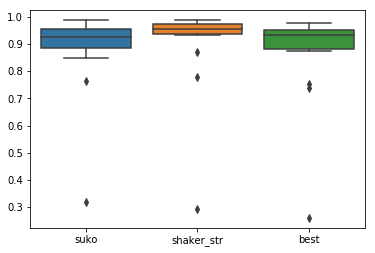

In [7]:
import pandas
import numpy as np
index=  ['suko',"shaker_str","best","shaker","nodata"]
data2 = [corr_suko, corr_shaker_str,corr_theo,corr_shaker,corr_nodata]


import seaborn as sns
sns.boxplot(data=pandas.DataFrame(data2[:3], index=index[:3]).T)

plt.title("SOME TITLE")
plt.grid()

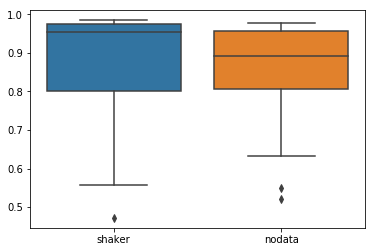

In [8]:
import seaborn as sns
sns.boxplot(data=pandas.DataFrame(data2[3:], index=index[3:]).T)
plt.title("SOME TITLE")
plt.grid()

In [9]:
map(lambda x:x.append(np.mean(x)),data2)    
data2 = pandas.DataFrame(data2, columns=keys+['mean'], index=index).T
from tabulate import tabulate
print tabulate(data2, headers="keys", tablefmt="orgtbl")

|            |     suko |   shaker_str |     best |   shaker |   nodata |
|------------+----------+--------------+----------+----------+----------|
| TRP5       | 0.952988 |     0.978142 | 0.950267 | 0.975742 | 0.975396 |
| 5srRNA     | 0.762879 |     0.780132 | 0.736296 | 0.979866 | 0.978867 |
| GLYCFN     | 0.319059 |     0.294153 | 0.260131 | 0.558528 | 0.520805 |
| RNAsep     | 0.882688 |     0.956563 | 0.925426 | 0.969952 | 0.847748 |
| adenin     | 0.959056 |     0.96678  | 0.973729 | 0.96678  | 0.877654 |
| Z-CIDGMP-1 | 0.95541  |     0.957053 | 0.931686 | 0.968699 | 0.978766 |
| ZHCV       | 0.8471   |     0.871347 | 0.753561 | 0.855613 | 0.905179 |
| MDLOOP     | 0.973381 |     0.97815  | 0.945245 | 0.977119 | 0.948119 |
| srRNA      | 0.944194 |     0.975469 | 0.950318 | 0.471877 | 0.55039  |
| p564       | 0.932584 |     0.954719 | 0.957856 | 0.783417 | 0.793642 |
| tRNAphe    | 0.910442 |     0.9501   | 0.931654 | 0.925303 | 0.631888 |
| ZGLY       | 0.917372 |     0.931114

In [10]:
print data2.to_latex()

\begin{tabular}{lrrrrr}
\toprule
{} &      suko &  shaker\_str &      best &    shaker &    nodata \\
\midrule
TRP5       &  0.952988 &    0.978142 &  0.950267 &  0.975742 &  0.975396 \\
5srRNA     &  0.762879 &    0.780132 &  0.736296 &  0.979866 &  0.978867 \\
GLYCFN     &  0.319059 &    0.294153 &  0.260131 &  0.558528 &  0.520805 \\
RNAsep     &  0.882688 &    0.956563 &  0.925426 &  0.969952 &  0.847748 \\
adenin     &  0.959056 &    0.966780 &  0.973729 &  0.966780 &  0.877654 \\
Z-CIDGMP-1 &  0.955410 &    0.957053 &  0.931686 &  0.968699 &  0.978766 \\
ZHCV       &  0.847100 &    0.871347 &  0.753561 &  0.855613 &  0.905179 \\
MDLOOP     &  0.973381 &    0.978150 &  0.945245 &  0.977119 &  0.948119 \\
srRNA      &  0.944194 &    0.975469 &  0.950318 &  0.471877 &  0.550390 \\
p564       &  0.932584 &    0.954719 &  0.957856 &  0.783417 &  0.793642 \\
tRNAphe    &  0.910442 &    0.950100 &  0.931654 &  0.925303 &  0.631888 \\
ZGLY       &  0.917372 &    0.931114 &  0.905664 &  0

In [11]:
"""
from scipy.stats import spearmanr as spear
corr = lambda ac1, ac2:[(a-b)**2 for k in keys for a,b in zip(ac1[k], ac2[k])]
corr_suko =  corr(acc_suko, acc_shape)
corr_shaker =  corr(acc_shaker, acc_shape)
corr_shaker_str =  corr(acc_shaker_str, acc_shape)
corr_nodata =  corr(acc_nodata, acc_shape)
print len(corr_suko)

import pandas
index= ['suko',"shaker","shaker_str","nodata"]
data2 = [corr_suko,corr_shaker, corr_shaker_str,corr_nodata]
data2 = pandas.DataFrame(data2, index=index).T
print data2.plot(kind='box')
"""

'\nfrom scipy.stats import spearmanr as spear\ncorr = lambda ac1, ac2:[(a-b)**2 for k in keys for a,b in zip(ac1[k], ac2[k])]\ncorr_suko =  corr(acc_suko, acc_shape)\ncorr_shaker =  corr(acc_shaker, acc_shape)\ncorr_shaker_str =  corr(acc_shaker_str, acc_shape)\ncorr_nodata =  corr(acc_nodata, acc_shape)\nprint len(corr_suko)\n\nimport pandas\nindex= [\'suko\',"shaker","shaker_str","nodata"]\ndata2 = [corr_suko,corr_shaker, corr_shaker_str,corr_nodata]\ndata2 = pandas.DataFrame(data2, index=index).T\nprint data2.plot(kind=\'box\')\n'

---